In [1]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from ultralytics.models.yolo.detect.train import DetectionModel
import torch

%reload_kedro
model_description = catalog.load("yolov8_l_description")
# trained_model = catalog.load("trained_model", version="2023-03-23T12.37.00.000Z")
trained_model = torch.load("../checkpoints/checkpoint_30338.pt", map_location="cpu")

# Random model
# encoder = YoloEncoder(model_description=model_description)
# trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov5l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

projection = trained_model.projection
trained_model = trained_model.encoder
trained_model = trained_model.eval()
projection = projection.eval()

2023-03-27 14:13:22,048 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:12: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) < LooseVersion("1.0.0"):

2023-03-27 14:13:22,048 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/thop/profile.py:68: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(torch.__version__) >= LooseVersion("1.1.0"):

2023-03-27 14:13:22,166 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-27 14:13:22,166 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/pyth

2023-03-27 14:13:22.410 | WARNING  | self_supervised.extras.datasets.pytorch_model_data_set:_load:42 - CUDA not available, automatically mapping variables to the CPU.


In [2]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")

In [3]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch
from typing import Tuple, List
import numpy as np

def extract_image_reps(image_list: List[Path]) -> Tuple[List[np.array], List[np.array]]:
    image_reps = []
    image_reps_low_dim = []

    for image_path in tqdm(image_list):
        image = read_image(image_path.as_posix())
        image.requires_grad = False
        image = resize(image, (512, 512))
        image = image.to(torch.float) / 255
        image_ex = image[None, :, :, :]

        image_rep = trained_model(image_ex).detach()
        image_reps.append(image_rep[0].reshape((1, -1)).numpy())
        image_reps_low_dim.append(projection(image_rep)[0].detach().reshape((1, -1)).numpy())
                          
    return image_reps, image_reps_low_dim


def extract_image_reps_dir(image_dir_: Path) -> Tuple[List[np.array], List[np.array]]:
    image_list = sorted(list(image_dir_.iterdir()))
    return extract_image_reps(image_list)

In [4]:
# Extract image reps.
ground_image_reps_1, _ = extract_image_reps_dir(dataset_path / "ssl_active_3" / "images")
ground_image_reps_2, _ = extract_image_reps_dir(dataset_path / "ssl_active_4" / "images")
aerial_image_reps_1, _ = extract_image_reps_dir(dataset_path / "active_1" / "images")
aerial_image_reps_2, _ = extract_image_reps_dir(dataset_path / "2018-08-22" / "images")

100%|████████████████████████████████████████████████████| 160/160 [00:25<00:00,  6.40it/s]


In [10]:
import pandas as pd
from typing import List
import numpy as np

def read_labels(labels_dir: Path, image_reps: List[np.array]) -> List[int]:
    all_labels = []
    labels_list = sorted(list(labels_dir.iterdir()))
    for labels_path in labels_list:
        frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
        frame_labels["frame"] = labels_path.name
        all_labels.append(frame_labels)

    all_labels = pd.concat(all_labels, ignore_index=True)
    
    # Create flower counts labels.
    flower_counts = []
    for labels_path in labels_list:
        flower_counts.append(np.count_nonzero(all_labels["frame"] == labels_path.name))

    # Any missing counts are zeros.
    for _ in range(len(flower_counts), len(image_reps)):
        flower_counts.append(0)
        
    return flower_counts

In [11]:
# Extract flower counts.
ground_counts_1 = read_labels(dataset_path / "ssl_active_3" / "labels", ground_image_reps_1)
ground_counts_2 = read_labels(dataset_path / "ssl_active_4" / "labels", ground_image_reps_2)
aerial_counts_1 = read_labels(dataset_path / "active_1" / "labels", aerial_image_reps_1)
aerial_counts_2 = read_labels(dataset_path / "2018-08-22" / "labels", aerial_image_reps_2)

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

def compute_tsne(image_reps: np.array, labels: np.array, perplexity: int = 10, **kwargs) -> pd.DataFrame:
    pca = PCA(n_components=50)
    pca.fit(image_reps)
    pca_reps = pca.transform(image_reps)

    tsne = TSNE(perplexity=perplexity)
    embedded_reps = tsne.fit_transform(pca_reps)

    # Combine embeddings with plot status data.
    return pd.DataFrame(data=dict(x=embedded_reps[:, 0], y=embedded_reps[:, 1], labels=labels, **kwargs))

In [15]:
all_counts = np.array(ground_counts_1 + ground_counts_2 + aerial_counts_1 + aerial_counts_2)
all_image_reps = np.concatenate(ground_image_reps_1 + ground_image_reps_2 + aerial_image_reps_1 + aerial_image_reps_2)

# Combine embeddings with number of flowers and source data.
platform_type = ["ground" for _ in ground_image_reps_1 + ground_image_reps_2] + ["aerial" for _ in aerial_image_reps_1 + aerial_image_reps_2]
embedded_df = compute_tsne(all_image_reps, all_counts, Platform=platform_type, perplexity=100)
embedded_df.rename({"labels": "# of Flowers"}, axis="columns", inplace=True)
embedded_df

,x,y,num_flowers,platform
0,9.597203,-36.160416,2,ground
1,9.627851,-36.371716,2,ground
2,9.986639,-36.361328,2,ground
3,9.961180,-36.659893,2,ground
4,10.292375,-36.575184,2,ground
...,...,...,...,...
1106,-22.694836,-7.567948,6,aerial
1107,-27.722752,-9.409860,2,aerial
1108,-25.865850,-22.626467,1,aerial
1109,-22.702257,-20.481615,3,aerial


2023-03-27 14:41:14,215 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":

2023-03-27 14:41:14,218 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)



[Text(0.5, 1.0, 't-SNE Embedding of Validation Datasets')]

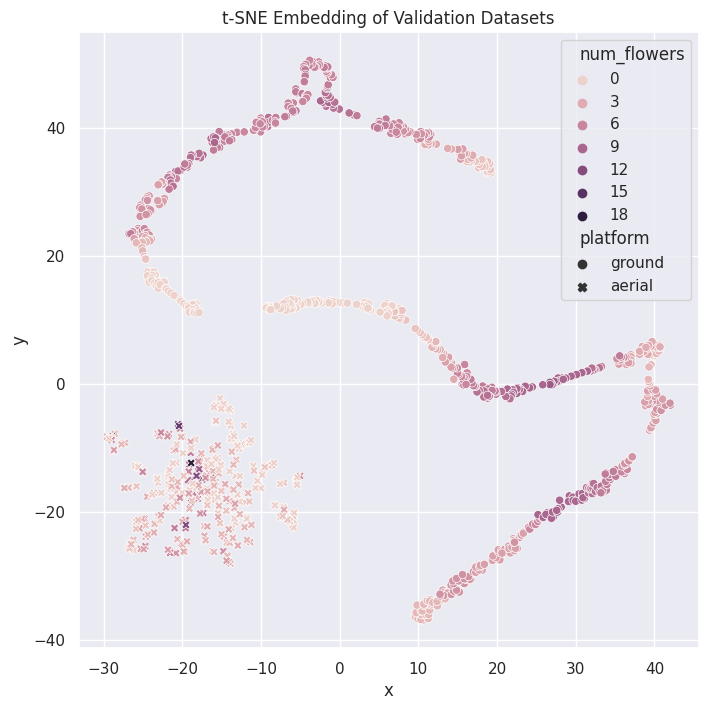

In [24]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize":(8, 8)})

sns.scatterplot(data=embedded_df, x="x", y="y", hue="Platform").set(title="t-SNE Embedding of Validation Datasets")
plt.legend(title="Platform")

In [ ]:
# Compute TSNE for aerial only.
aerial_embedded_df = compute_tsne(np.concatenate(aerial_image_reps_1 + aerial_image_reps_2, axis=0), np.array(aerial_counts_1 + aerial_counts_2).astype(int), perplexity=10)
aerial_embedded_df.rename({"labels": "# of Flowers"}, axis="columns", inplace=True)
aerial_embedded_df

In [ ]:
sns.scatterplot(data=aerial_embedded_df, x="x", y="y", hue="# of Flowers").set(title="t-SNE Embedding of Aerial Dataset")

In [ ]:
# Compute TSNE for ground only.
ground_embedded_df = compute_tsne(np.concatenate(ground_image_reps_1 + ground_image_reps_2, axis=0), np.array(ground_counts_1 + ground_counts_2).astype(int), perplexity=10)
ground_embedded_df.rename({"labels": "# of Flowers"}, axis="columns", inplace=True)
ground_embedded_df

In [ ]:
sns.scatterplot(data=ground_embedded_df, x="x", y="y", hue="# of Flowers").set(title="t-SNE Embedding of Ground Dataset")

In [ ]:
# Load the plot status data.
PLOT_STATUS_DATA_PATH = Path("/home/daniel/lab_share/projects/SSL/plot_status_dataset")
train_dir = PLOT_STATUS_DATA_PATH / "train"
test_dir = PLOT_STATUS_DATA_PATH / "test"

LABEL_MAP = {"in_plot": 0, "between_plots": 1, "headland": 2}

def collect_images_and_labels(data_dir: Path) -> Tuple[List[Path], np.array]:
    image_paths = []
    labels = []

    for category_dir in data_dir.iterdir():
        for image_path in category_dir.iterdir():
            image_paths.append(image_path)
            labels.append(LABEL_MAP[category_dir.name])

    return image_paths, np.array(labels)

train_images, train_labels = collect_images_and_labels(train_dir)
test_images, test_labels = collect_images_and_labels(test_dir)

In [ ]:
# Compute image representations.
train_image_reps, _ = extract_image_reps(train_images)
test_image_reps, _ = extract_image_reps(test_images)

In [ ]:
plot_status_embedded_df = compute_tsne(np.concatenate(train_image_reps + test_image_reps), np.concatenate([train_labels, test_labels]), perplexity=5)
plot_status_embedded_df.rename({"labels": "Plot Status"}, axis="columns", inplace=True)
plot_status_embedded_df

In [ ]:
import seaborn as sns

sns.scatterplot(data=plot_status_embedded_df, x="x", y="y", hue="Plot Status").set(title="t-SNE Embedding of Ground Dataset")